In [4]:
%config AsyncShell.timeout = 300  # Increase to 300 seconds
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pandas as pd
import sklearn
import pyarrow

In [3]:
import mlflow
import sqlite3

# Here we set the tracking URI to a local SQLite database named "mlflow.db".
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# Next we set the experiment name to "nyc-taxi-experiment".
# First, let's delete the experiment permanently from the database

# Connect to the SQLite database
conn = sqlite3.connect("mlflow.db")
cursor = conn.cursor()

# Delete the experiment from the experiments table
cursor.execute("DELETE FROM experiments WHERE name = ?", ("nyc-taxi-experiment",))

# Commit the changes and close the connection
conn.commit()
conn.close()

# Now we can create a new experiment with the same name
mlflow.set_experiment("nyc-taxi-experiment")

2025/05/25 15:40:19 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1748187619913, experiment_id='1', last_update_time=1748187619913, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

## Q1. What is the version of MlFlow that we currently use?

In [13]:
!mlflow --version

/home/codespace/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/codespace/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
mlflow, version 2.22.0


## Q2. Download and preprocess the data

In [16]:
# Download the data for Green Taxi Trips from 2023 january to March
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-03.parquet

# Moving the downloaded files to the data directory
!mkdir -p data
!mv green_tripdata_2023-01.parquet data/
!mv green_tripdata_2023-02.parquet data/
!mv green_tripdata_2023-03.parquet data/

--2025-05-25 16:02:05--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.239.38.163, 18.239.38.181, 18.239.38.83, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|18.239.38.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1427002 (1.4M) [binary/octet-stream]
Saving to: ‘green_tripdata_2023-01.parquet’

green_tripdata_2023 100%[===================>]   1.36M  --.-KB/s    in 0.01s   

2025-05-25 16:02:05 (137 MB/s) - ‘green_tripdata_2023-01.parquet’ saved [1427002/1427002]

--2025-05-25 16:02:05--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.239.38.181, 18.239.38.83, 18.239.38.147, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|18.239.38.181|:443... connected.
HTTP request sent, 

### Preprocessing the data using the `preprocess_data` function

In [ ]:
# Preprocess the data and save it as a DictVectorizer object
!python preprocess_data.py --raw_data_path data --dest_path ./dataset_as_DictVectorizer/

/home/codespace/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/codespace/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## Q3. Train a model with autolog

Get the size of the data set. How much memory it Takes?

In [19]:
# Getting info about the dataframe and the used memory size
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               category      
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        category      
 4   trip_distance          float64       
 5   RatecodeID             category      
 6   store_and_fwd_flag     category      
 7   PULocationID           category      
 8   DOLocationID           category      
 9   payment_type           category      
 10  fare_amount            float64       
 11  extra                  category      
 12  mta_tax                category      
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  category      
 16  total_amount           float64       
 17  congestion_surcharge   category      
 18  airport_fee           

In [20]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


In [21]:
# Adding new feature to get the trip distance
df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds / 60

In [9]:
(
    df
    [['trip_distance', 'duration']]
    .sort_values('duration', ascending=False)
    .head(10)
)
# The top 10 trips by trip_time all have extremely high values,
# indicating likely data errors or outliers.

,trip_distance,duration
2460754,16.83,1439.800000
127500,1.55,1439.650000
271181,24.48,1439.633333
1598991,8.63,1439.616667
2359185,2.19,1439.583333
2069061,12.64,1439.466667
927194,9.73,1439.433333
1910535,3.99,1439.433333
229908,19.54,1439.383333
2881681,1.52,1439.366667


In [10]:
# number of passengers takes only one of 11 values, so it's better to convert it into category data type
len(df['passenger_count'].unique())

11

In [11]:
# How many unique values at each feature?
df.nunique().sort_values()

VendorID                       2
store_and_fwd_flag             2
congestion_surcharge           3
airport_fee                    3
improvement_surcharge          5
payment_type                   5
RatecodeID                     7
passenger_count               10
mta_tax                       10
extra                         68
PULocationID                 257
DOLocationID                 261
tolls_amount                 776
tip_amount                  4036
trip_distance               4387
fare_amount                 6873
duration                    8570
total_amount               15871
tpep_pickup_datetime     1610975
tpep_dropoff_datetime    1611319
dtype: int64

In [12]:
# get the names of columns with values less than 300 which will be converted into category
categorical_columns = (df.nunique().loc[lambda _df: _df < 300] ).index.to_list()
print(categorical_columns)
df[categorical_columns] = df[categorical_columns].astype('category')

['VendorID', 'passenger_count', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'airport_fee']


In [10]:
# How much space we saved using after converting into categorical?
df.info(memory_usage='deep')
# we save more than 300MB which is more than 50% of the original size of the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               category      
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        category      
 4   trip_distance          float64       
 5   RatecodeID             category      
 6   store_and_fwd_flag     category      
 7   PULocationID           category      
 8   DOLocationID           category      
 9   payment_type           category      
 10  fare_amount            float64       
 11  extra                  category      
 12  mta_tax                category      
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  category      
 16  total_amount           float64       
 17  congestion_surcharge   category      
 18  airport_fee           

### 2. Computing duration

In [11]:
std_january_duration = df['duration'].std()
print(f"Standard deviation of trip durations in January: {std_january_duration}")

Standard deviation of trip durations in January: 41.62919110962406


### 3. Dropping outliers

In [12]:
# To remove outlier we make the duration only between 1 and 60 minutes.
df = df.query(" duration >=1 and duration <= 60")

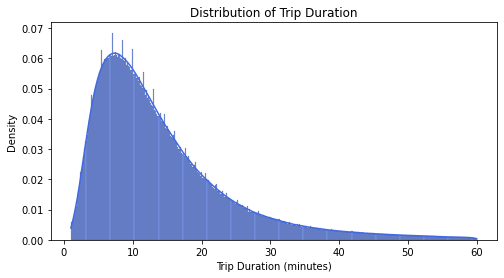

In [13]:
plt.figure(figsize=(8, 4))
sns.histplot(df['duration'], kde=True, stat='density', color='royalblue', alpha=0.7)
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Density')
plt.title('Distribution of Trip Duration')
plt.show()

In [14]:
size_of_clean_df = df.shape[0]/ 3066766 * 100
print(f"The size of the data set after dropping the outlier: {size_of_clean_df:0.2f} %")

The size of the data set after dropping the outlier: 98.12 %


### 4. One-hot encoding

In [15]:
categorical = ['PULocationID', 'DOLocationID']
df[categorical] = df[categorical].astype(str)
numerical = ['trip_distance']
train_dicts = df[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

# We will use the DictVectorizer to convert the categorical features into a one-hot encoded format
# and the numerical features will be used as is.
# We will use the DictVectorizer to convert the categorical features into a one-hot encoded format

In [16]:
# Print the dimensionality (number of columns)
print(f"Feature matrix shape: {X_train.shape}")

Feature matrix shape: (3009176, 516)


### 5. Training a model

In [17]:
import time
start = time.time()

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

end = time.time()
print(f"Time taken to train the model: {end - start}")
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
print(f'Train RMSE: {rmse_train}')

Time taken to train the model: 19.22462034225464
Train RMSE: 7.649152894155631


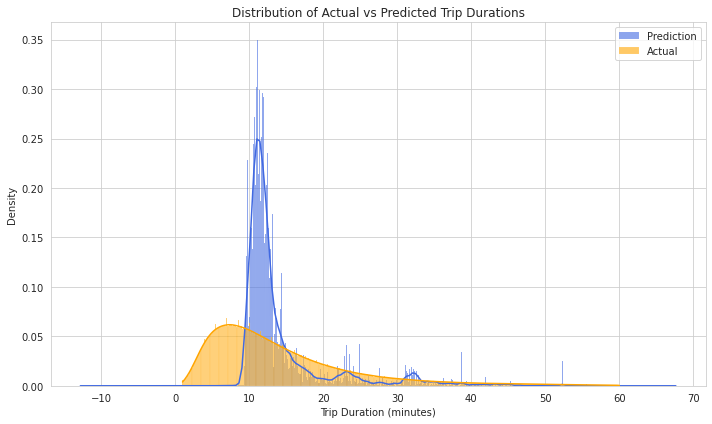

In [18]:
# the actual vs the predicted values
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.histplot(y_pred, label='Prediction', color='royalblue', kde=True, stat='density', alpha=0.6)
sns.histplot(y_train, label='Actual', color='orange', kde=True, stat='density', alpha=0.6)
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Density')
plt.title('Distribution of Actual vs Predicted Trip Durations')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Getting the validation set which is the data set for february
# We will use the same features as in January, but we will not use the target variable
df_february  = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet', engine='pyarrow')
df_february['duration'] = (df_february['tpep_dropoff_datetime'] - df_february['tpep_pickup_datetime']).dt.seconds / 60
df_february = df_february.query(" duration >=1 and duration <= 60")
df_february.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,4.4,3.50,0.5,0.00,0.0,1.0,9.40,2.5,0.00,1.683333
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,70.9,2.25,0.5,0.00,0.0,1.0,74.65,0.0,1.25,32.083333
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,17.0,1.00,0.5,3.30,0.0,1.0,25.30,2.5,0.00,13.300000
5,1,2023-02-01 00:52:40,2023-02-01 01:07:18,1.0,5.10,1.0,N,148,236,1,21.9,3.50,0.5,5.35,0.0,1.0,32.25,2.5,0.00,14.633333
6,1,2023-02-01 00:12:39,2023-02-01 00:40:36,1.0,8.90,1.0,N,137,244,1,41.5,3.50,0.5,3.50,0.0,1.0,50.00,2.5,0.00,27.950000


In [20]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df_february[categorical] = df_february[categorical].astype(str)

In [ ]:
test_dicts = df_february[categorical + numerical].to_dict(orient='records')

: 

### 6. Evaluating the model

In [22]:
# Test using the february as test set
start = time.time()
X_test = dv.transform(test_dicts)

target = 'duration'
y_test = df_february[target].values

y_pred = lr.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
end = time.time()
print(f"Time taken to test the model: {end - start}")
print(f'Validation RMSE: {rmse_test}')

: 

: 

In [ ]:
# Save the trained Linear Regression model
with open('linear_regression_model.pkl', 'wb') as f_model:
    pickle.dump(lr, f_model)

# Save the fitted DictVectorizer
with open('dict_vectorizer.pkl', 'wb') as f_dv:
    pickle.dump(dv, f_dv)